In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load LLM

In [2]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    device_map="auto",   
    torch_dtype=torch.float16,
)
print(f"finish loading model")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


finish loading tokenizer


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

## Generate time series

In [12]:
time_series_name = 'Brownian motion'

Nt = 1001 # number of steps
a = 0 # drift

# other hyper-parameters
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)
sigma = 0.8

random_seed = 7

np.random.seed(random_seed)
# Initialize the time series
x = 0  # Starting point
time_series = [x]
mean_series = [x]
sigma_series = [0]

# Generate the drift-diffusion time series
for t in range(1, Nt):
    x_mean = x + a*dt
    x_sigma = sigma * np.sqrt(dt)
    dW = np.random.normal()  # Wiener process (Brownian motion)
    x = x_mean + x_sigma * dW
    
    time_series.append(x)
    mean_series.append(x_mean)
    sigma_series.append(x_sigma)

## Define trainer and ICL

In [13]:
from llmicl.interfaces import trainers  # import RLICLTrainer

# if you have modified the code since importing for the first time, reload will update the imported package
import importlib
importlib.reload(trainers)

<module 'llmicl.interfaces.trainers' from '/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py'>

In [14]:
context_length = 1000
rescale_factor = 7.0
up_shift = 1.5

trainer = trainers.UnivariateICLTrainer(
    model=model,
    tokenizer=tokenizer,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=np.array(time_series), 
    mean_series=np.array(mean_series), 
    sigma_series=np.array(sigma_series), 
    context_length=context_length
)

trainer.icl()

icl_object = trainer.compute_statistics()

## Visualize

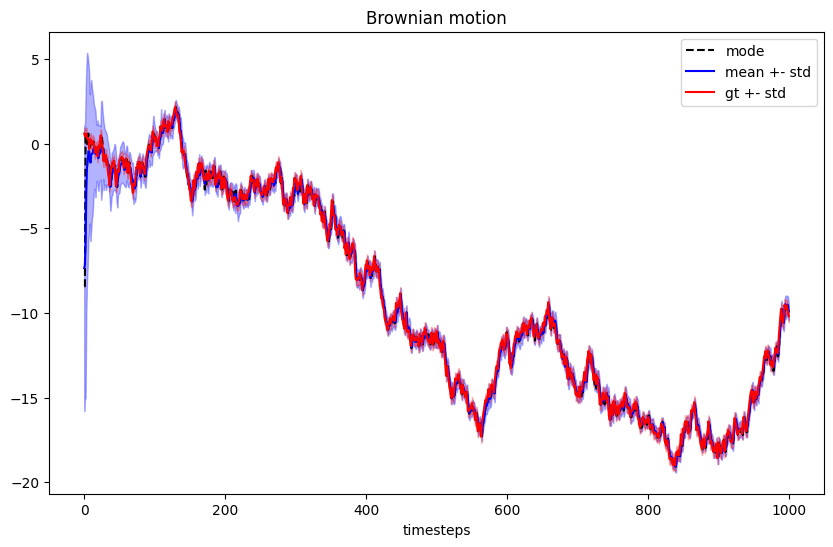

In [15]:
plt.figure(figsize=(10,6))
groundtruth = np.array(time_series[1:context_length+1])
gt_sigma = np.array(sigma_series[1:context_length+1])

ts_max = icl_object.rescaling_max
ts_min = icl_object.rescaling_min

mode_arr = ((icl_object.mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
mean_arr = ((icl_object.mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
sigma_arr = (icl_object.sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

x = np.arange(mean_arr.shape[0])

# ----------------- mode -----------------
plt.plot(x, mode_arr, 'k--',label='mode')

# ----------------- predicted mean +- std -----------------
plt.plot(x, mean_arr, label='mean +- std', color='blue')
plt.fill_between(x=x, y1=mean_arr-sigma_arr, y2=mean_arr+sigma_arr, color='blue', alpha=.3)

# ----------------- groundtruth mean +- std -----------------
plt.plot(x, groundtruth, label='gt +- std', color='red')
plt.fill_between(x=x, y1=groundtruth-gt_sigma, y2=groundtruth+gt_sigma, color='red', alpha=.3)

plt.title(f"{time_series_name}")
plt.xlabel("timesteps")
plt.legend()
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()

## GIF

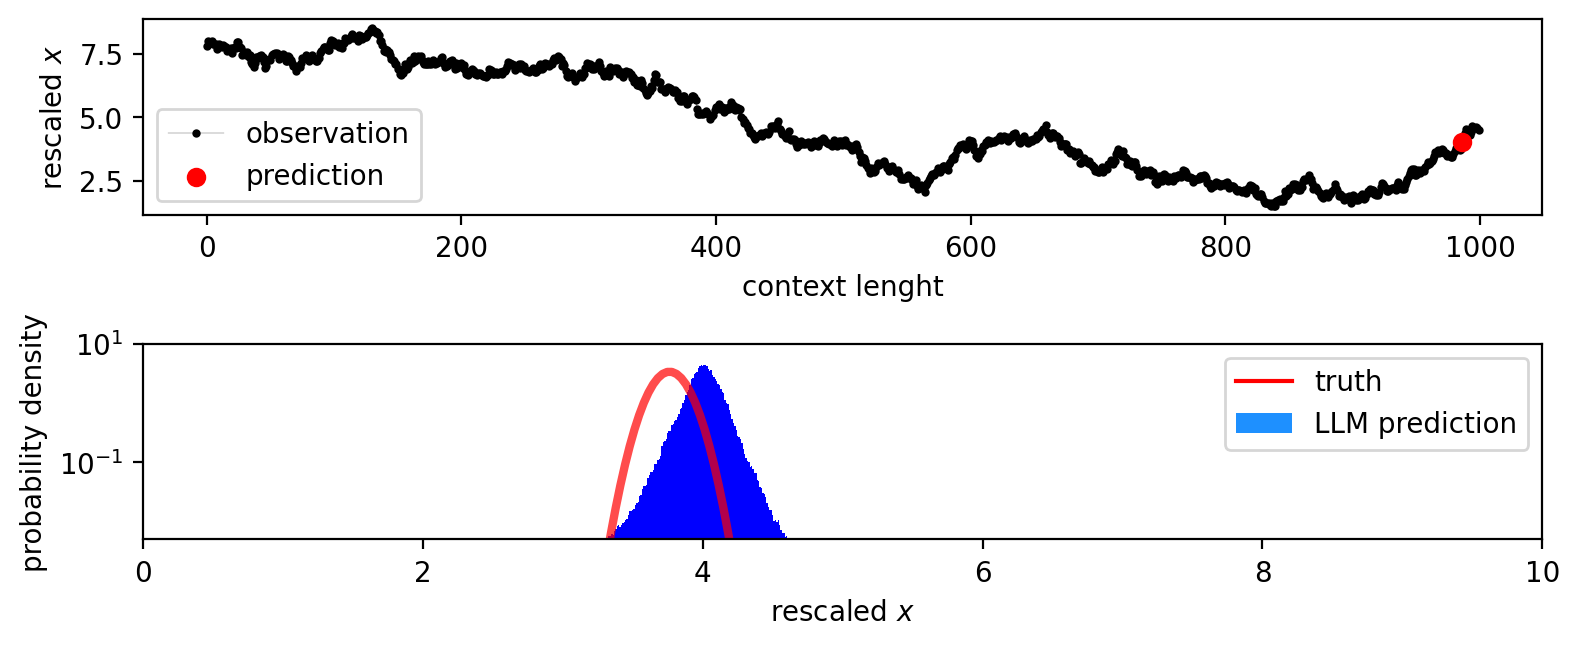

interactive(children=(IntSlider(value=986, description='comma_idx', max=2958, min=-986), Output()), _dom_class…

In [16]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import norm
import copy


### Load multiple digits to MultiResolutionPDF
comma_locations = np.sort(np.where(np.array(list(icl_object.str_series)) == ',')[0])
time_series_rescaled = (time_series-icl_object.rescaling_min) / (icl_object.rescaling_max-icl_object.rescaling_min) * (8.5-1.5) + 1.5
PDF_list = icl_object.PDF_list

plot1_log_scale = 0
log_scale = 1
temp_list = [1]
final_state = None
filenames = []
### Plot distribution before ith comma
def digiprob_plotter(comma_idx=1):
    if comma_idx == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[comma_idx-1]+1

    fig, axs = plt.subplots(1+len(temp_list), 1, figsize=(8, 5/3*(1+len(temp_list))), dpi = 200)
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.7)
    # Plot the full array with a marker on the selected value
    if final_state is not None:
        time_series_plot = time_series_rescaled[:final_state+1]
    else:
        time_series_plot = time_series_rescaled
    # axs[0].scatter(comma_idx, time_series_plot[comma_idx], color='r', marker='o', label = "prediction")
    # axs[0].plot(time_series_plot[:-1], marker='o', color='black', markersize=2, lw = '0.1', label = "observation")
    axs[0].plot(time_series_plot[:-1], marker='o', color='black', markersize=2, lw='0.1', label="observation", zorder=1)
    axs[0].scatter(comma_idx, time_series_plot[comma_idx], color='r', marker='o', label="prediction", zorder=2)
    axs[0].set_xlabel('context lenght')
    axs[0].set_ylabel(r'rescaled $x$')
    if final_state is not None:
        axs[0].set_xlim(-10, final_state+10)
    if plot1_log_scale:
        axs[0].set_yscale('log')
        
    for i, temp in enumerate(temp_list):
    # Plot softmax distributions for each digit
        axs[i+1].set_ylabel("probability density")
        if len(temp_list) > 1:
            axs[i+1].set_title(f"LLM temperature = {temp}") 
        
        PDF_copied = copy.deepcopy(PDF_list[comma_idx])
        PDF_copied.rescale_temperature(temp)
        PDF_copied.compute_stats()
        PDF_copied.plot(ax = axs[i+1], log_scale=log_scale, statistic = False)
        if log_scale:
            axs[1].set_ylim(0.005,10)

        # characterizing ground truth distribution
        true_mean = icl_object.rescaled_true_mean_arr[comma_idx]
        true_sigma = icl_object.rescaled_true_sigma_arr[comma_idx]
        if true_sigma == 0:
            axs[i+1].vlines(true_mean, 0, np.max(PDF_list[comma_idx].bin_height_arr), color='r', label='Truth', lw = 3, alpha = 0.7)
        else:
            x_values = np.linspace(0, 10, 300)
            gaussian = norm.pdf(x_values, true_mean, true_sigma)
            axs[i+1].plot(x_values, gaussian, color = 'r', lw = 3, alpha = 0.7)

        # axs[1].bar([0], [0], lw = 3, color='lightseagreen', label='bin of width 1')
        # axs[1].bar([0], [0], lw = 3, color='blue', label='bin of width 0.01')
        axs[1].bar([0], [0], lw = 3, color='dodgerblue', label='LLM prediction')
        axs[1].plot([0], [0], color='r', label='truth')
        
        axs[i+1].set_xlabel(r'rescaled $x$')
        axs[i+1].legend()
        axs[i+1].set_xlim(0,10)
        if len(temp_list) > 1:
            axs[i+1].set_ylim(0,2.6)    

    axs[0].legend(loc="lower left")

    plt.tight_layout()
    # save_path = f"../figures/BM_example_snapshot_{comma_idx}.png"
    # filenames.append(save_path)
    # plt.savefig(save_path)

# Adjust the range of the slider to match the number of commas in the series
num_commas = icl_object.str_series.count(',')
snapshots = [1,2,3,4,5,6,10,100,200,300,400,500,600,700,800,900,986]
for snapshot in snapshots:
    interact(digiprob_plotter, comma_idx=snapshot)